In [1]:
import numpy as np
import scipy.optimize as opt
from scipy.integrate import quad
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class pr_eos():
    '''Peng-Robinson Cubic
    Equation of State class'''
    def __init__(self,fluid,T):
        '''Instatiates fluid and
        temperature'''
        self.fluid = fluid
        self.T = T
    
    def pr_coefs(self):
        '''Calculates fluid critical
        properties and PR coefficient'''
        M = CP.PropsSI('molarmass',self.fluid)
        Tc = CP.PropsSI('Tcrit',self.fluid)
        pc = CP.PropsSI('Pcrit',self.fluid)        
        omega = CP.PropsSI('acentric',self.fluid)
        self.b = 0.07780 * (R/M) * Tc / pc
        alpha = 1 + (0.37464 + 1.54226 * omega - \
                0.26992 * omega**2) * (1 - np.sqrt(self.T / Tc))
        self.a = 0.45724 *( (R * Tc/M) ** 2) * alpha ** 2 / pc   
        self.M = M
        return(self.a,self.b,self.M,self.T)    
    
    def p_sat(self,guess):
        '''Solves for the saturation pressure
        via the Maxwell equal area rule'''
        p_sat = opt.fsolve(maxwell,guess)
        return(p_sat)

    
def vols(p_guess):
    '''Solves the PR equation in the
    cubic dimensionless form'''
    a,b,M,T = pr.pr_coefs()
    Rw = R/M
    p = p_guess
    A_mult = p / (Rw * T) ** 2
    B_mult = p / (Rw * T)
    a3 = 1
    a2 = 1 - B_mult*b
    a1 = A_mult * a - 3 * (B_mult * b) ** 2\
                                   - 2 * B_mult * b
    a0 = A_mult * a * B_mult * b -(B_mult * b) ** 2\
                                - (B_mult * b) ** 3
    coeff = [a3,-a2,a1,-a0]
    vol = np.roots(coeff) * Rw * T / p_guess
    v_l, v_v = np.min(vol), np.max(vol)
    return(v_l, v_v,a,b,M,T)

def maxwell(guess):
    '''Calculates Maxwell equal area rule'''
    v_l, v_v, a, b, M, T = vols(guess)
    integ = quad(lambda v: ((R/M) * T / (v - b)
                        - a / (v**2 + 2*v*b - b**2)),v_l,v_v,epsabs=0)
    return(integ[0] - guess*(v_v - v_l))

/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
 

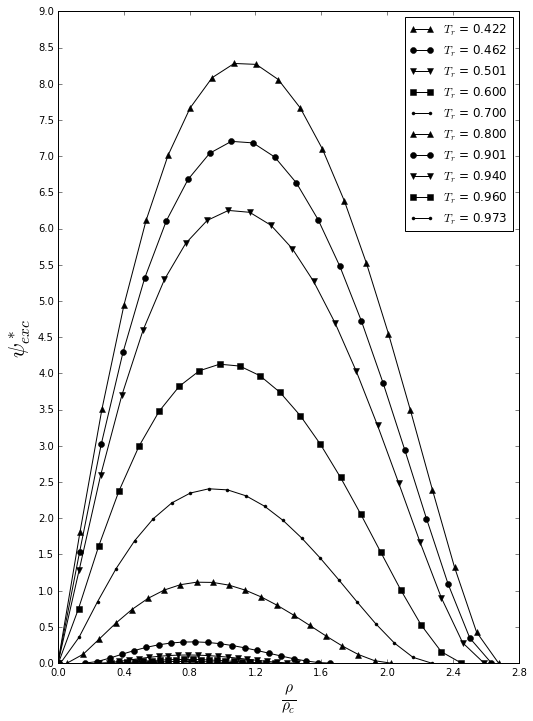

In [3]:
R = 8.314
Tr = [0.4220,0.4622,0.5008,0.5997,0.7001,0.8005,
      0.9009,0.9395,0.9596,0.973]
rhoc = CP.PropsSI('rhocrit','water')
pc = CP.PropsSI('pcrit','water')
Tc = CP.PropsSI('Tcrit','water')
psat = 101325
fig1,ax1 = plt.subplots(ncols=1,figsize=(8.26,11.68))
lines = ['-k^','-ko','-kv','-ks','-k.','-k^','-ko','-kv','-ks','-k.']
psis = {}
for i,tr in enumerate(Tr):
    temp = tr * Tc
    pr = pr_eos('water',temp)
    psat = pr.p_sat(psat)
    v_l,v_v,a,b,M,T = vols(psat)    
    rho_range = np.linspace(1/v_l,1/v_v,21)
    psi = []
    for k in rho_range:
        psi.append(k*quad(lambda rho: (rho*(R/M)*T/(1 - rho*b) -
                a * rho**2 /(1 + 2 * rho * b - (rho * b)**2 ))/
                          rho**2 - psat/rho**2,rho_range[0],k)[0])
    psi = np.array(psi)
    psis[tr] = psi
    ax1.plot(rho_range / rhoc, psi / pc, 
             lines[i], label = r'$T_r$ = %0.3f' %Tr[i])
ax1.legend(loc='upper right')
ax1.set_ylabel(r'$\psi_{exc}^*$',fontsize=22)
ax1.set_xlabel(r'$\frac{\rho}{\rho_c}$',fontsize=22)
ax1.set_xticks(np.linspace(0,2.8,8));
ax1.set_yticks(np.linspace(0,9,19));
ax1.set_xlim([0,2.8]);
ax1.set_ylim([0,9]);

In [4]:
Tr = np.array([0.5,0.6,0.7])
psat = 101325
for i, tr in enumerate(Tr):
    temp = tr * Tc
    pr = pr_eos('water',temp)
    psat = pr.p_sat(psat)
    v_l,v_v,a,b,M,T = vols(psat)    
    rho_range = np.linspace(1/v_l,1/v_v,21)
    rhor = rho_range/rhoc
    psi = []
    for k in rho_range:
        psi.append(k*quad(lambda rho: (rho*(R/M)*T/(1 - rho*b) -
                a * rho**2 /(1 + 2 * rho * b - (rho * b)**2 ))/
                          rho**2 - psat/rho**2,rho_range[0],k)[0])
    psi = np.array(psi)
    I = [np.sqrt(x/pc) if x > 0 else 0 for x in psi]
    I = np.trapz(I,x=np.flipud(rhor))    
    kappa = (CP.PropsSI('I','T',temp,'Q',0,'water') / (rhoc * I * np.sqrt(2*pc)))**2
    lbda = rhoc * np.sqrt(kappa / pc) * (rhor[0] - rhor[-1]) / (np.sqrt(2 * max(psi)/pc))
    print(lbda)
    print(kappa)

3.36692552173e-10
4.51193595267e-17
4.27765198553e-10
5.35728622123e-17
5.59826008533e-10
6.32356772614e-17


/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


### van der Waals

In [5]:
class vdw_eos():
    '''Peng-Robinson Cubic
    Equation of State class'''
    def __init__(self,fluid,T):
        '''Instatiates fluid and
        temperature'''
        self.fluid = fluid
        self.T = T
    
    def vdw_coefs(self):
        '''Calculates fluid critical
        properties and vdw coefficient'''
        M = CP.PropsSI('molarmass',self.fluid)
        Tc = 647.3
        pc = 22120000
        self.b = (R/M) * Tc / (8 * pc)
        self.a = 27 *( (R * Tc/M) ** 2) / (64 * pc)   
        self.M = M
        return(self.a,self.b,self.M,self.T)    
    
    def p_sat_vdw(self,guess):
            '''Solves for the saturation pressure
            via the Maxwell equal area rule'''
            p_sat = opt.fsolve(maxwell_vdw,guess)
            return(p_sat)

    
def vols_vdw(p_guess):
    '''Solves the vdw equation in the
    cubic dimensionless form'''
    a,b,M,T = vdw.vdw_coefs()
    Rw = R/M
    p = p_guess
    a3 = 1
    a2 = Rw*T / p + b
    a1 = a / p
    a0 = a * b / p
    coeff = [a3,-a2,a1,-a0]
    vol = np.roots(coeff) * Rw * T / p
    v_l, v_v = np.min(vol), np.max(vol)
    return(v_l, v_v,a,b,M,T)

def maxwell_vdw(guess):
    '''Calculates Maxwell equal area rule'''
    v_l, v_v, a, b, M, T = vols_vdw(guess)
    integ = quad(lambda v: (R/M) * T / (v - b)
                        - a / (v**2),v_l,v_v,epsabs=0)
    return(integ[0] - guess*(v_v - v_l))

In [6]:
T = 300#0.8*647.3
vdw = vdw_eos('water',T)
pr = 0.0162
rho_lr,rho_vr = 2.50801,0.01353
#rho_lr,rho_vr = 1.93279,0.23962
kappa = 5.18317*10**(-16)
#kappa = 1.37541*10**(-15)
Tc,Pc,rhoc = 647.3,221.2*10**5,197.29

In [7]:
def integ(start,stop):
    integr = quad(lambda x: np.sqrt(3*x*rho_vr * (1 - x/rho_vr) + 8*x*(T/Tc)/3 *
         np.log(x*(3-rho_vr)/(rho_vr*(3-x))) + (1 - x/rho_vr) *
         (8*rho_vr*T/Tc / (3 - rho_vr) - 3*rho_vr ** 2)),start,stop)[0]
    return(integr)
gamma_lv = integ(rho_vr,rho_lr)*rhoc*np.sqrt(2*Pc*kappa)
gamma_lv

0.070090266085334432

In [60]:
def sistema(chute):
        
    x,y = chute[0],chute[1]
    phi1,phi2 = phis(x,y)    
    gamma_ls,gamma_vs = gammas(x,y)        
    return(np.cos(13*np.pi/180) * gamma_lv + gamma_ls - gamma_lv,
          phi1 - phi2)

def phis(x,y):
    phi1 = np.sqrt(2) * np.sqrt(3*x*rho_lr * (1 - x/rho_lr)
            + 8*x*(T/Tc)/3 * np.log(x*(3-rho_lr)/(rho_lr*(3-x)))
            + (1 - x/rho_lr) * (8*rho_lr*(T/Tc) / (3 - rho_lr)
                                                - 3*rho_lr ** 2))    
    phi2 = np.sqrt(2) * np.sqrt(3*y*rho_vr * (1 - y/rho_vr)
            + 8*y*(T/Tc)/3 * np.log(y*(3-rho_vr)/(rho_vr*(3-y)))
            + (1 - y/rho_vr) * (8*rho_vr*(T/Tc) / (3 - rho_vr)
                                                - 3*rho_vr ** 2))
    return(phi1,phi2)

def gammas(x,y):
    phi1,phi2 = phis(x,y)
    gamma_ls = -rhoc*x*phi1*np.sqrt(Pc*kappa) + integ(rho_lr,x) *\
                rhoc * np.sqrt(2*Pc*kappa)
        
    gamma_vs = -rhoc*y*phi2*np.sqrt(Pc*kappa) + integ(rho_vr,y) *\
                rhoc * np.sqrt(2*Pc*kappa)
    return(gamma_ls,gamma_vs)
    
chut = opt.fsolve(sistema,(2.7779477,0.4065784))
print(chut,rho_lr,rho_vr)
print(gammas(chut[0],chut[1]))
print(phis(chut[0],chut[1]))

[ 2.7779477  0.4065784] 2.50801 0.01353
(-0.072070409920552456, -0.0044271245739785125)
(1.2879402305933316, 1.2879353824405837)


/home/julionaojulho/.local/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in log
/home/julionaojulho/.local/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


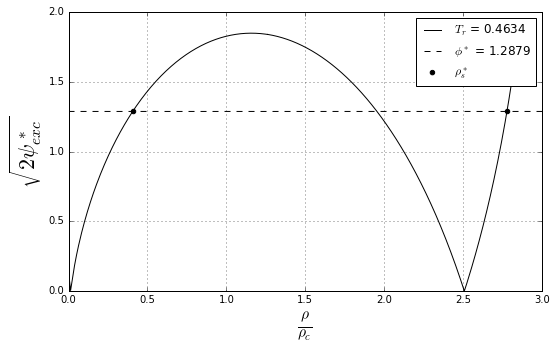

In [61]:
#rho_lr,rho_vr = 1.93279,0.23962
#T = 0.8*Tc
rhr = np.linspace(rho_vr-rho_vr/2,(rho_lr+rho_vr)/2,200)
rhr2 = np.linspace((rho_lr+rho_vr)/2,rho_lr+rho_lr/8,200)
pls = []
pls2 = []
for y in rhr:
    if y != rho_lr:
        pls.append(np.sqrt(2) * np.sqrt(3*y*rho_vr * (1 - y/rho_vr)
            + 8*y*(T/Tc)/3 * np.log(y*(3-rho_vr)/(rho_vr*(3-y)))
            + (1 - y/rho_vr) * (8*rho_vr*(T/Tc) / (3 - rho_vr)
                                                - 3*rho_vr ** 2)))
    else:
        pls.append(0)
for y in rhr2:
    pls2.append(np.sqrt(2) * np.sqrt(3*y*rho_lr * (1 - y/rho_lr)
            + 8*y*(T/Tc)/3 * np.log(y*(3-rho_lr)/(rho_lr*(3-y)))
            + (1 - y/rho_lr) * (8*rho_lr*(T/Tc) / (3 - rho_lr)
                                                - 3*rho_lr ** 2)))

plt.figure(figsize=(6*np.sqrt(2),5))
plt.plot(rhr,pls,'k',label=r'$T_r$ = 0.4634')
plt.plot([0,3],phis(chut[0],chut[1]),'--k',\
         label=r'$\phi^*$ = %0.4f' %phis(chut[0],chut[1])[0])
plt.scatter(chut,phis(chut[0],chut[1]),color='k',label=r'$\rho_s^*$')
plt.plot(rhr2,pls2,'k')
plt.legend(loc='upper right',scatterpoints=1)
plt.ylabel(r'$\sqrt{2\psi_{exc}^*}$',fontsize=22)
plt.xlabel(r'$\frac{\rho}{\rho_c}$',fontsize=22)
plt.ylim([0,2]);
plt.xlim([0,3]);
plt.grid('on')